# 30-Day Hospital Readmission Risk — Clinical Analytics Notebook

**Clinical aim.** Estimate 30-day readmission risk at discharge to prioritize proactive outreach (early clinic visit, medication reconciliation, home health). The model is designed to support value-based care and reduce avoidable readmissions.

**Dataset.** `data/hospital_readmissions_30k.csv`  
**Outcome.** `readmitted_30_days` ∈ {Yes, No} (mapped to 1/0)  
**Repository.** https://github.com/albertokabore/Hospital-Readmission-Prediction

**Decision framing.**  
- Primary: *Recall (Sensitivity)* — identify high-risk patients to avoid missed opportunities.  
- Secondary: *Precision* — efficient use of follow-up resources.  
- Summary: AUROC and AUPRC given class imbalance.

**Method overview.**  
- Robust preprocessing (impute, encode, scale).  
- Baselines + ensembles (DT, RF, GB, AdaBoost, Bagging, XGBoost).  
- Imbalance strategies (SMOTE, undersampling).  
- Hyperparameter tuning with `RandomizedSearchCV`.  
- Interpretability (feature importance / coefficients).


In [348]:
!pip install scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn


In [349]:
!pip install --upgrade -q threadpoolctl


In [350]:
# Import all required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    f1_score, accuracy_score, recall_score, precision_score,
    confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [351]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.style.use("seaborn-v0_8-whitegrid")

RANDOM_STATE = 42
DATA_PATH = "Dataset_Hospital_readmissions_30k.csv"  # adjust path if needed

print(" HOSPITAL READMISSION ANALYSIS INITIALIZED")

 HOSPITAL READMISSION ANALYSIS INITIALIZED


In [352]:
import os

print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())

Current working directory: c:\Users\alber\Hospital-Readmission-Prediction\notebooks
Files here: ['Readmission_Project.ipynb']


## 0. CONFIGURATION


In [353]:
import os

target_name = "Dataset_Hospital_readmissions_30k.csv"
found_paths = []

for dirpath, dirnames, filenames in os.walk(os.getcwd()):
    if target_name in filenames:
        found_paths.append(os.path.join(dirpath, target_name))

print("Found paths:")
for p in found_paths:
    print(" -", p)


Found paths:


In [354]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


## 1. DATA LOADING AND INITIAL EXPLORATION


### load data

In [355]:
print("\n" + "=" * 70)
print("1. DATA LOADING AND INITIAL EXPLORATION")
print("=" * 70)


1. DATA LOADING AND INITIAL EXPLORATION


In [356]:
df = pd.read_csv(r"C:\Users\alber\Hospital-Readmission-Prediction\data\Dataset_Hospital_readmissions_30k.csv")


In [357]:
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns\n")

Dataset loaded: 30000 rows, 12 columns



In [358]:
print("Column dtypes:")
print(df.dtypes.value_counts(), "\n")

print("First 5 rows:")
print(df.head(), "\n")

Column dtypes:
object     6
int64      5
float64    1
Name: count, dtype: int64 

First 5 rows:
   patient_id  age  gender blood_pressure  cholesterol    bmi diabetes  \
0           1   74   Other         130/72          240 31.500      Yes   
1           2   46  Female         120/92          292 36.300       No   
2           3   89   Other         135/78          153 30.300       No   
3           4   84  Female         123/80          153 31.500       No   
4           5   32   Other         135/84          205 18.400       No   

  hypertension  medication_count  length_of_stay discharge_destination  \
0           No                 5               1      Nursing_Facility   
1           No                 4               3      Nursing_Facility   
2          Yes                 1               1                  Home   
3          Yes                 3              10                  Home   
4          Yes                 6               4      Nursing_Facility   

  readmitted_3

In [359]:
print("Memory usage: "
      f"{df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB")

Memory usage: 10.46 MB


### Checking for missing values


In [360]:
# Missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    "MissingCount": missing_values,
    "MissingPct": missing_percentage
}).sort_values("MissingPct", ascending=False)

print("\nMissing values summary (top 20):")
print(missing_df.head(20))



Missing values summary (top 20):
                       MissingCount  MissingPct
patient_id                        0       0.000
age                               0       0.000
gender                            0       0.000
blood_pressure                    0       0.000
cholesterol                       0       0.000
bmi                               0       0.000
diabetes                          0       0.000
hypertension                      0       0.000
medication_count                  0       0.000
length_of_stay                    0       0.000
discharge_destination             0       0.000
readmitted_30_days                0       0.000


In [361]:
# Describe numeric and categorical
numeric_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_all = df.select_dtypes(
    include=["object", "category", "bool"]
).columns.tolist()

print(f"\nNumeric features: {len(numeric_cols_all)}")
print(numeric_cols_all)
print(f"\nCategorical features: {len(categorical_cols_all)}")
print(categorical_cols_all)

print("\nDescriptive statistics (numeric):")
print(df[numeric_cols_all].describe().T)


Numeric features: 6
['patient_id', 'age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay']

Categorical features: 6
['gender', 'blood_pressure', 'diabetes', 'hypertension', 'discharge_destination', 'readmitted_30_days']

Descriptive statistics (numeric):
                     count      mean      std     min      25%       50%  \
patient_id       30000.000 15000.500 8660.398   1.000 7500.750 15000.500   
age              30000.000    53.884   21.056  18.000   36.000    54.000   
cholesterol      30000.000   225.260   43.586 150.000  188.000   225.000   
bmi              30000.000    28.946    6.348  18.000   23.400    28.900   
medication_count 30000.000     5.012    3.166   0.000    2.000     5.000   
length_of_stay   30000.000     5.503    2.867   1.000    3.000     5.000   

                       75%       max  
patient_id       22500.250 30000.000  
age                 72.000    90.000  
cholesterol        263.000   300.000  
bmi                 34.500    40.000  
medic

## =============================================================================
## 2. TARGET VARIABLE ANALYSIS
## =============================================================================

In [362]:
print("\n" + "=" * 70)
print("2. TARGET VARIABLE ANALYSIS")
print("=" * 70)

# Try a few common target names, starting with 'readmitted'
candidate_targets = ["readmitted", "readmitted_30_days", "Readmitted"]
target_col = None

for col in candidate_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    print("Available columns:\n", df.columns.tolist())
    raise ValueError("Target column not found. Check the actual name in df.columns.")

print(f"Using target column: {target_col}")

# If target is not already 0/1, map typical text values to 0/1
if df[target_col].dtype == "object":
    # you can extend this mapping if your values are different
    mapping = {
        "Yes": 1, "No": 0,
        "Y": 1, "N": 0,
        "Readmitted": 1, "Not Readmitted": 0,
        1: 1, 0: 0
    }
    df[target_col] = df[target_col].map(mapping)

# Safety check: make sure it is numeric now
if not np.issubdtype(df[target_col].dtype, np.number):
    print("Unique values in target:", df[target_col].unique())
    raise ValueError("Target column is not numeric and could not be mapped to 0/1.")

# Now compute distribution
target_distribution = df[target_col].value_counts().sort_index()
target_percentage = (target_distribution / len(df)) * 100

print("Target distribution (readmitted):")
for val, count in target_distribution.items():
    if val == 0:
        label = "Not Readmitted"
    elif val == 1:
        label = "Readmitted"
    else:
        label = f"Class {val}"
    print(f"• {label}: {count} patients ({target_percentage[val]:.2f}%)")



2. TARGET VARIABLE ANALYSIS
Using target column: readmitted_30_days
Target distribution (readmitted):
• Not Readmitted: 26326 patients (87.75%)
• Readmitted: 3674 patients (12.25%)


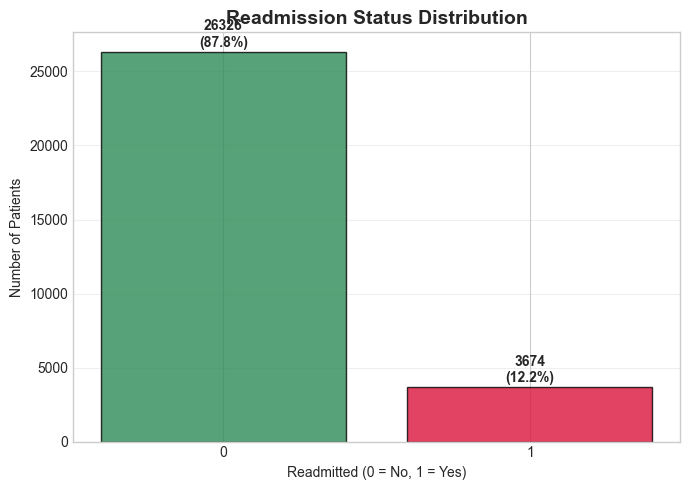

In [363]:
plt.figure(figsize=(7, 5))
colors = ["#2E8B57", "#DC143C"]
bars = plt.bar(target_distribution.index, target_distribution.values,
               color=colors, alpha=0.8, edgecolor="black")
plt.title("Readmission Status Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Readmitted (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.xticks([0, 1])
plt.grid(axis="y", alpha=0.3)
for idx, bar in enumerate(bars):
    height = bar.get_height()
    val = target_distribution.index[idx]
    pct = target_percentage[val]
    plt.text(bar.get_x() + bar.get_width() / 2, height + len(df) * 0.005,
             f"{height}\n({pct:.1f}%)", ha="center", va="bottom", fontweight="bold")
plt.tight_layout()
plt.show()


In [364]:
positive_rate = target_percentage.get(1, 0.0)
class_ratio = target_distribution[0] / max(target_distribution.get(1, 1), 1)
baseline_acc = target_percentage.max()

print("\nTarget summary:")
print(f"• Readmission rate: {positive_rate:.2f}%")
print(f"• Class imbalance ratio (0:1): {class_ratio:.2f}:1")
print(f"• Baseline accuracy (majority class): {baseline_acc:.2f}%")



Target summary:
• Readmission rate: 12.25%
• Class imbalance ratio (0:1): 7.17:1
• Baseline accuracy (majority class): 87.75%


## =============================================================================
##  3. EXPLORATORY DATA ANALYSIS (EDA)
## =============================================================================

In [365]:
# =============================================================================
print("\n" + "=" * 70)
print("3. EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 70)


3. EXPLORATORY DATA ANALYSIS (EDA)


In [366]:

# 3.1 Numeric feature list excluding target
numeric_cols = [c for c in numeric_cols_all if c != target_col]
print(f"Numeric features used for plots (excluding target): {len(numeric_cols)}")


Numeric features used for plots (excluding target): 6


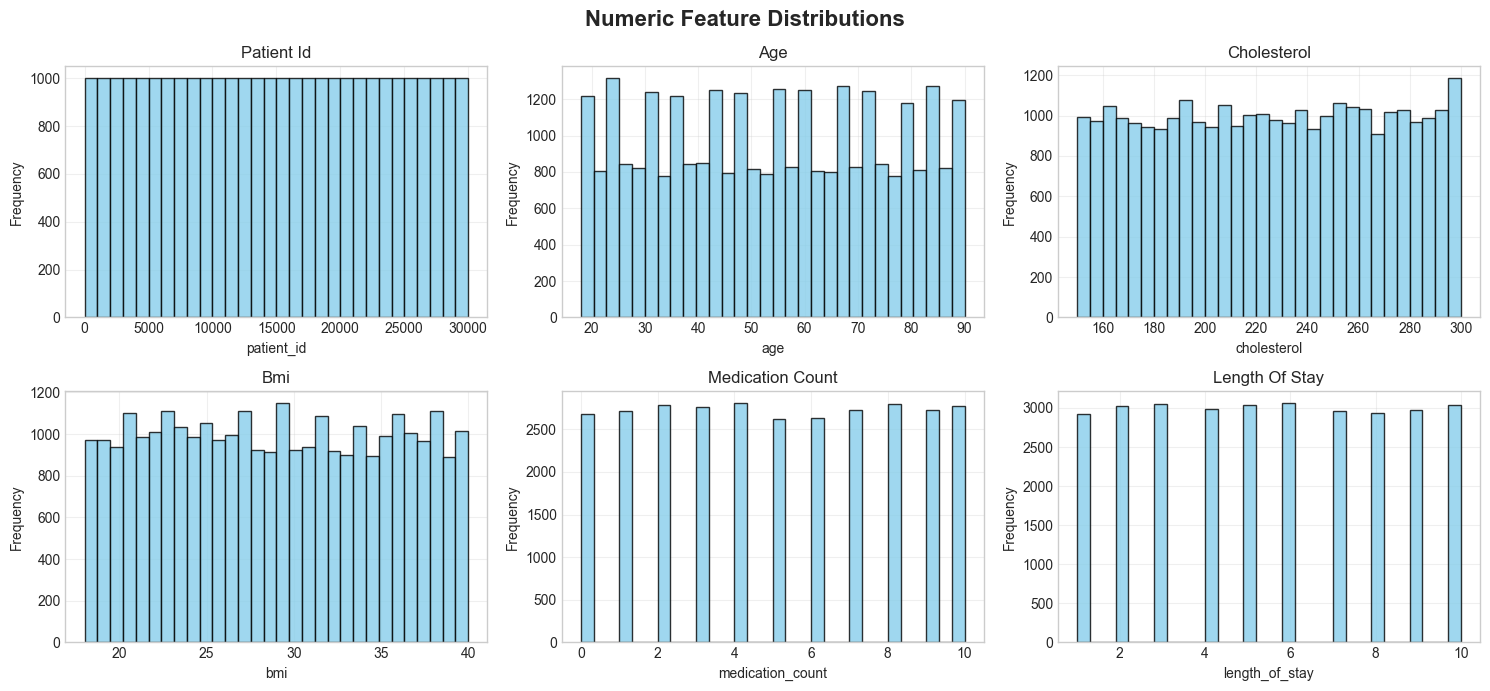

In [367]:
# 3.2 Histograms for numeric features
if numeric_cols:
    n_cols_plot = 3
    n_rows_plot = int(np.ceil(len(numeric_cols) / n_cols_plot))
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot,
                             figsize=(5 * n_cols_plot, 3.5 * n_rows_plot))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        ax.hist(df[col].dropna(), bins=30, color="skyblue",
                edgecolor="black", alpha=0.8)
        ax.set_title(col.replace("_", " ").title())
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.grid(alpha=0.3)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Numeric Feature Distributions", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

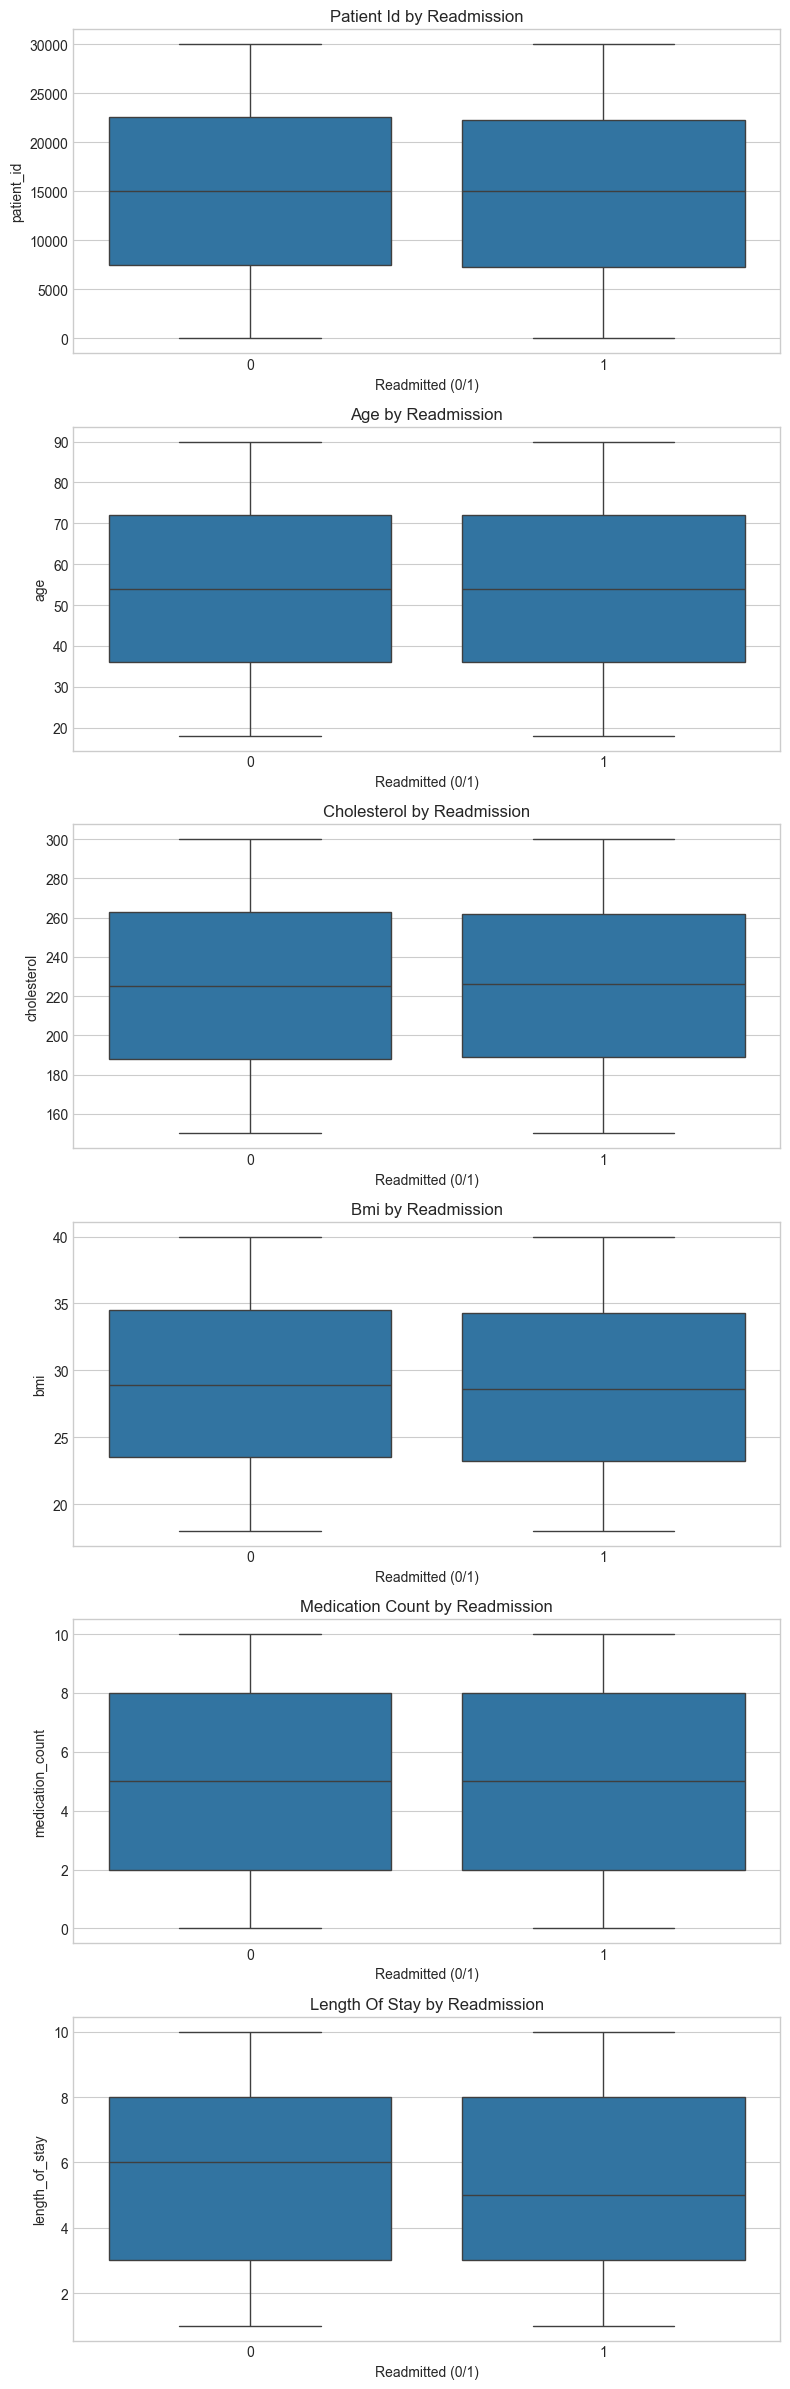

In [368]:

# 3.3 Boxplots of numeric features by target (top 6 for readability)
top_box_cols = numeric_cols[:6]
if top_box_cols:
    fig, axes = plt.subplots(len(top_box_cols), 1,
                             figsize=(8, 4 * len(top_box_cols)))
    if len(top_box_cols) == 1:
        axes = [axes]
    for i, col in enumerate(top_box_cols):
        sns.boxplot(data=df, x=target_col, y=col, ax=axes[i])
        axes[i].set_title(f"{col.replace('_', ' ').title()} by Readmission")
        axes[i].set_xlabel("Readmitted (0/1)")
        axes[i].set_ylabel(col)
    plt.tight_layout()
    plt.show()



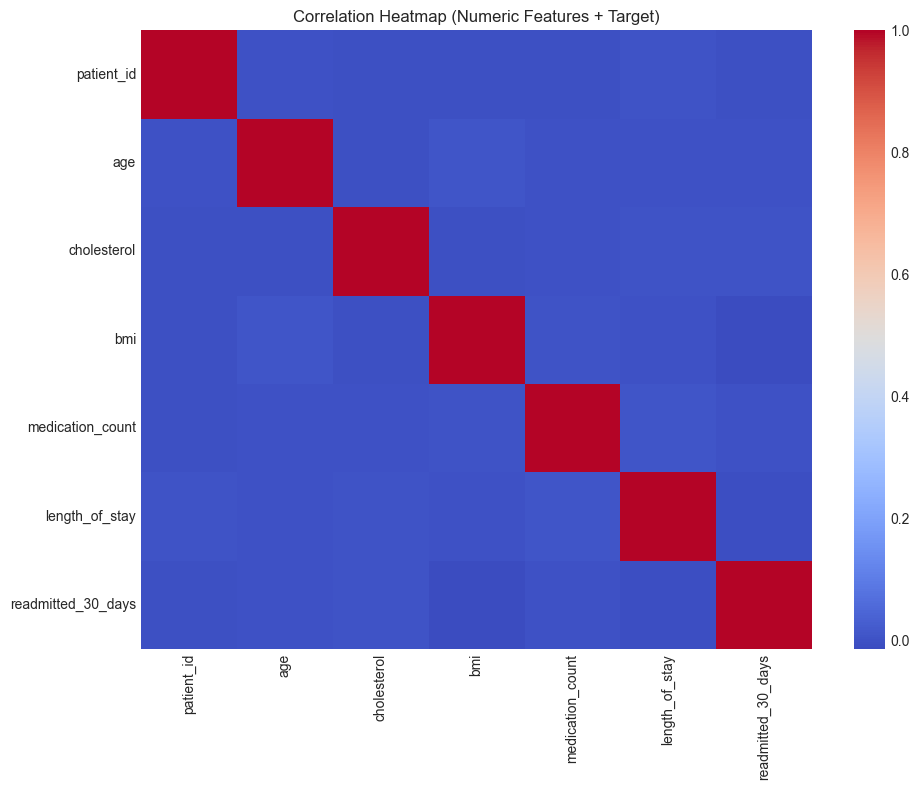


Top correlations with readmitted:
bmi                -0.013
length_of_stay     -0.007
patient_id         -0.005
cholesterol         0.004
age                 0.000
medication_count   -0.000
Name: readmitted_30_days, dtype: float64


In [369]:
# 3.4 Correlation heatmap (numeric)
if len(numeric_cols) >= 2:
    corr_cols = numeric_cols + [target_col]
    corr_matrix = df[corr_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", square=False)
    plt.title("Correlation Heatmap (Numeric Features + Target)")
    plt.tight_layout()
    plt.show()
  # Print top correlations with target
    print("\nTop correlations with readmitted:")
    target_corr = corr_matrix[target_col].drop(target_col).sort_values(
        key=lambda s: s.abs(), ascending=False)
    print(target_corr.head(10))



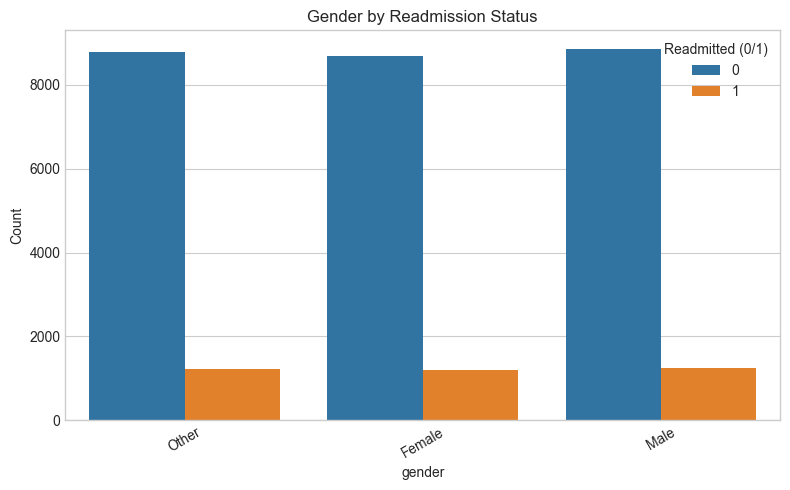

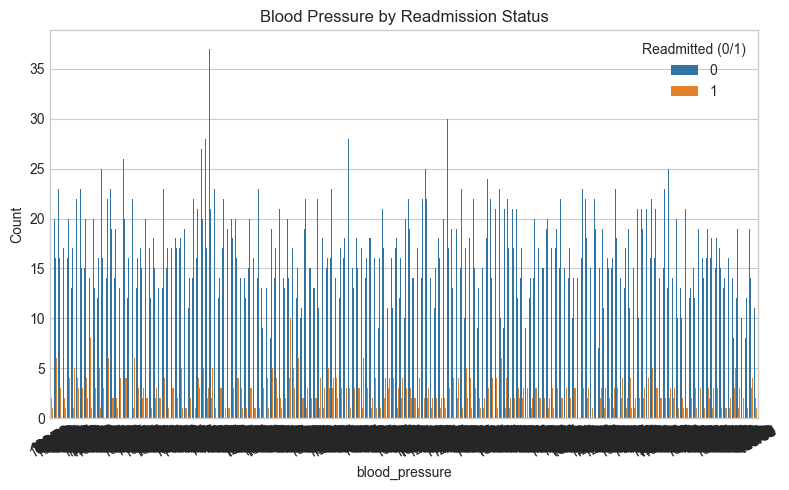

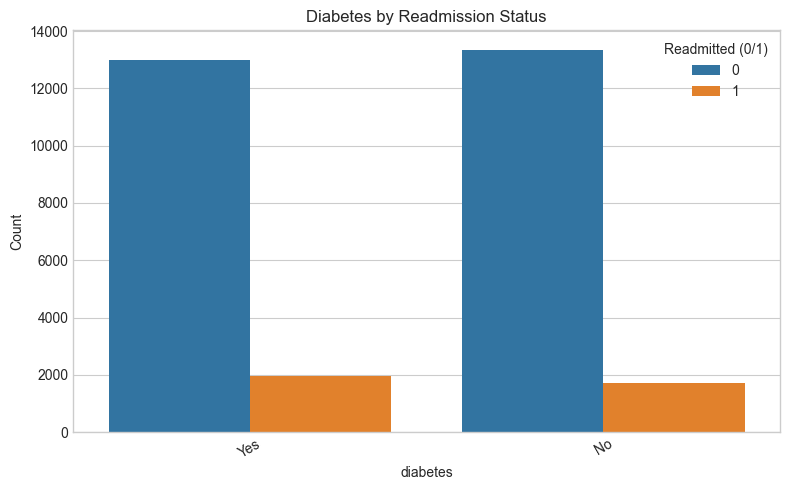

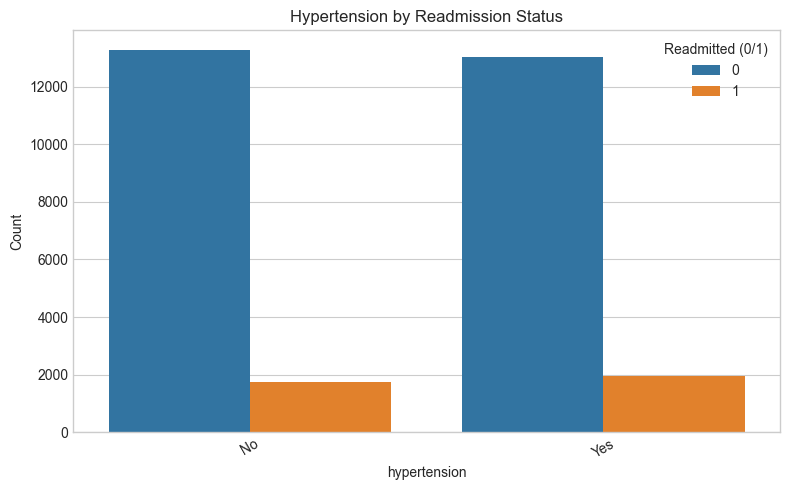

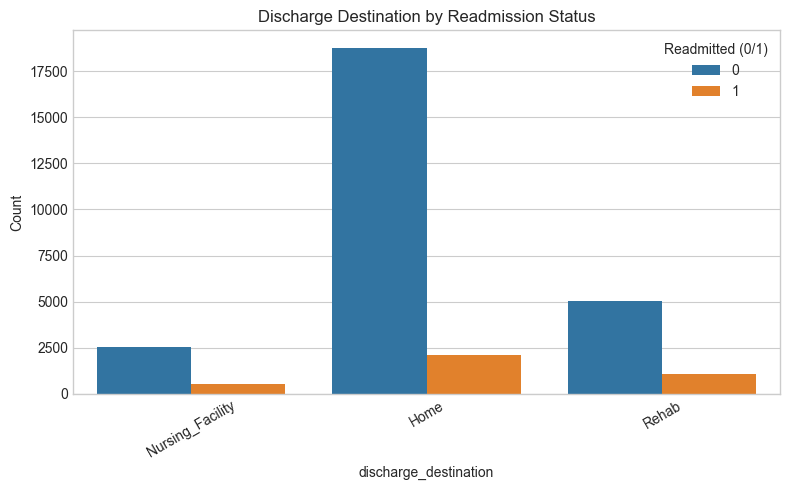

In [370]:

# 3.5 Categorical count plots vs target (up to 5)
cat_for_plots = categorical_cols_all[:5]
for col in cat_for_plots:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue=target_col)
    plt.title(f"{col.replace('_', ' ').title()} by Readmission Status")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.legend(title="Readmitted (0/1)")
    plt.tight_layout()
    plt.show()


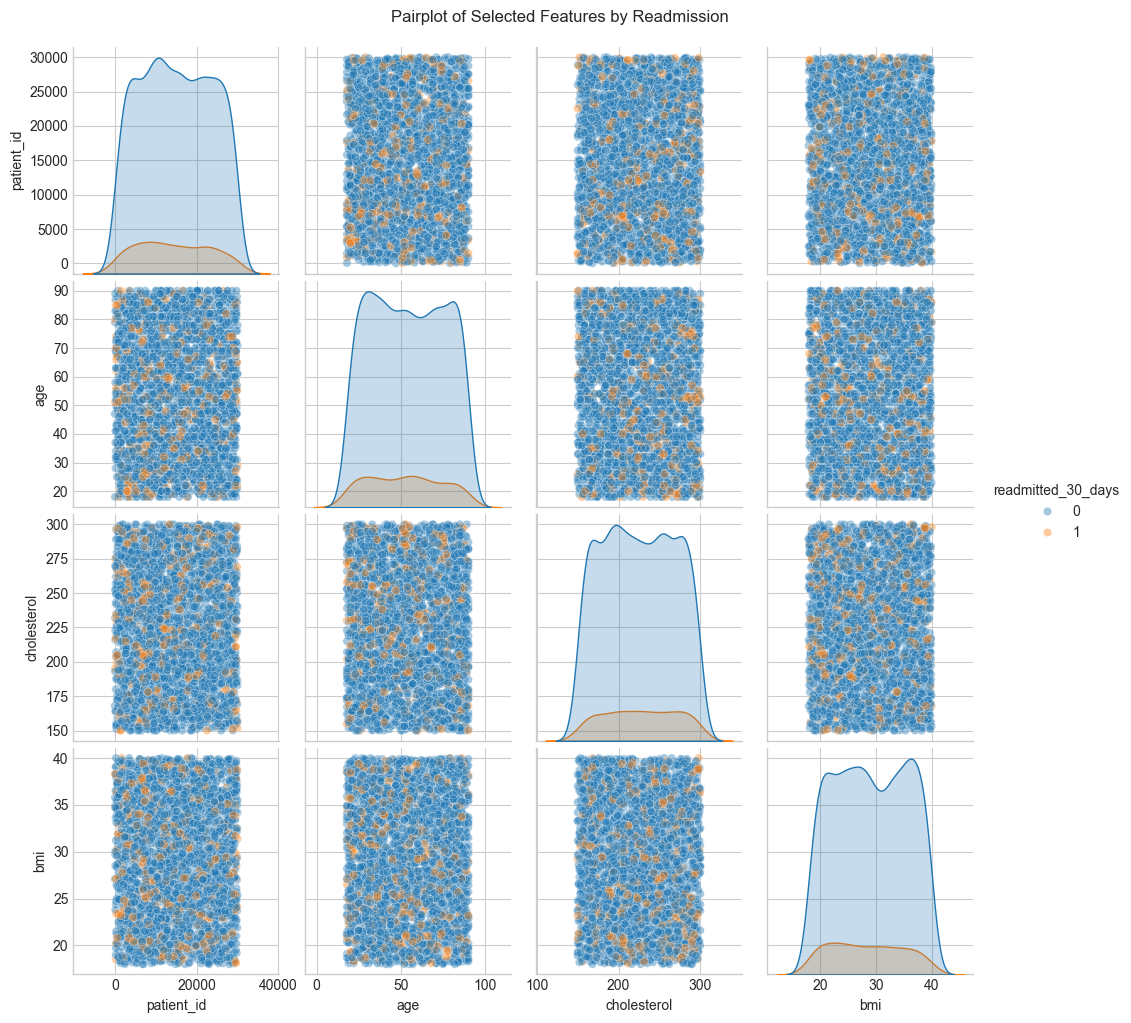

In [371]:
# 3.6 Pairplot (sample, top 4 numeric features)
pairplot_cols = numeric_cols[:4]
if len(pairplot_cols) >= 2:
    sample_df = df[pairplot_cols + [target_col]].copy()
    if len(sample_df) > 3000:
        sample_df = sample_df.sample(3000, random_state=RANDOM_STATE)
    sns.pairplot(sample_df, vars=pairplot_cols, hue=target_col,
                 diag_kind="kde", plot_kws={"alpha": 0.4})
    plt.suptitle("Pairplot of Selected Features by Readmission", y=1.02)
    plt.show()

# =============================================================================
# 4. FEATURE ENGINEERING
# =============================================================================

In [372]:
print("\n" + "=" * 70)
print("4. FEATURE ENGINEERING")
print("=" * 70)

df_engineered = df.copy()




4. FEATURE ENGINEERING


## =============================================================================
## 5. VALIDATION OF ENGINEERED FEATURES
## =============================================================================

In [373]:
# 4.1 Complexity score (using your classic hospital features if available)
print("Creating clinical complexity score where possible...")

complexity_base = [
    "time_in_hospital",
    "num_medications",
    "number_diagnoses"
]
available_complexity = [c for c in complexity_base if c in df_engineered.columns]

scaled_cols = []
for col in available_complexity:
    std_val = df_engineered[col].std()
    if std_val == 0 or np.isnan(std_val):
        df_engineered[f"{col}_scaled"] = 0.0
    else:
        df_engineered[f"{col}_scaled"] = (
            df_engineered[col] - df_engineered[col].mean()
        ) / std_val
    scaled_cols.append(f"{col}_scaled")

if scaled_cols:
    weights = np.ones(len(scaled_cols)) / len(scaled_cols)
    complexity_score = np.zeros(len(df_engineered))
    for w, col in zip(weights, scaled_cols):
        complexity_score += w * df_engineered[col]
    df_engineered["clinical_complexity_score"] = (
        (complexity_score - complexity_score.min())
        / (complexity_score.max() - complexity_score.min())
        * 100
    )

    conditions = [
        df_engineered["clinical_complexity_score"] < 25,
        df_engineered["clinical_complexity_score"] < 50,
        df_engineered["clinical_complexity_score"] < 75,
        df_engineered["clinical_complexity_score"] >= 75,
    ]
    choices = ["Low", "Medium", "High", "Very High"]
    df_engineered["complexity_category"] = np.select(
        conditions, choices, default="Medium"
    )

    print("• clinical_complexity_score and complexity_category created.")
else:
    print("• Not enough base features found to build complexity score.")



Creating clinical complexity score where possible...
• Not enough base features found to build complexity score.


In [374]:
# 4.2 Interaction features
print("Creating interaction features where possible...")

if {"time_in_hospital", "num_medications"}.issubset(df_engineered.columns):
    df_engineered["medications_per_day"] = (
        df_engineered["num_medications"] /
        df_engineered["time_in_hospital"].replace(0, np.nan)
    )
    df_engineered["medications_per_day"] = df_engineered[
        "medications_per_day"
    ].replace([np.inf, -np.inf], np.nan).fillna(
        df_engineered["num_medications"].median()
    )
    print("• medications_per_day created.")

if {"time_in_hospital", "number_diagnoses"}.issubset(df_engineered.columns):
    df_engineered["diagnoses_per_day"] = (
        df_engineered["number_diagnoses"] /
        df_engineered["time_in_hospital"].replace(0, np.nan)
    )
    df_engineered["diagnoses_per_day"] = df_engineered[
        "diagnoses_per_day"
    ].replace([np.inf, -np.inf], np.nan).fillna(
        df_engineered["number_diagnoses"].median()
    )
    print("• diagnoses_per_day created.")


Creating interaction features where possible...


In [375]:
# 4.3 Log / sqrt transforms for skewed count variables
print("Applying log and sqrt transforms (where available)...")
transform_candidates = [
    "time_in_hospital",
    "num_medications",
    "num_lab_procedures",
    "number_emergency",
    "number_inpatient",
    "number_outpatient",
    "number_diagnoses",
]
for col in transform_candidates:
    if col in df_engineered.columns:
        df_engineered[f"{col}_log"] = np.log1p(df_engineered[col])
        df_engineered[f"{col}_sqrt"] = np.sqrt(df_engineered[col])
        print(f"• {col}_log and {col}_sqrt created.")

engineered_features = [
    c for c in df_engineered.columns if c not in df.columns
]
print(f"\nTotal engineered features: {len(engineered_features)}")
print(engineered_features)


Applying log and sqrt transforms (where available)...

Total engineered features: 0
[]


In [376]:
print("Does 'clinical_complexity_score' exist?",
      "clinical_complexity_score" in df_engineered.columns)

print("\nFirst 10 columns of df_engineered:")
print(df_engineered.columns[:10])

# If you want to see all:
# print(df_engineered.columns.tolist())


Does 'clinical_complexity_score' exist? False

First 10 columns of df_engineered:
Index(['patient_id', 'age', 'gender', 'blood_pressure', 'cholesterol', 'bmi',
       'diabetes', 'hypertension', 'medication_count', 'length_of_stay'],
      dtype='object')


Building generic clinical_complexity_score from numeric features...

Numeric columns available (excluding target): ['patient_id', 'age', 'cholesterol', 'bmi', 'medication_count', 'length_of_stay']

Using these features to build clinical_complexity_score: ['patient_id', 'cholesterol', 'age', 'bmi', 'medication_count']

✅ clinical_complexity_score and complexity_category created.

Plotting distribution of clinical_complexity_score...


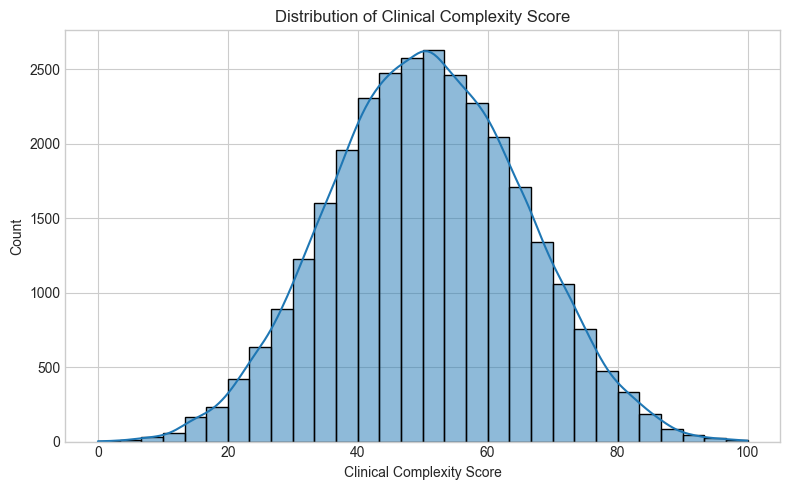

In [377]:


# Make sure df_engineered exists
df_engineered = df.copy()

print("Building generic clinical_complexity_score from numeric features...\n")

# 1) Select numeric columns (excluding target)
numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

print(f"Numeric columns available (excluding target): {numeric_cols}")

if len(numeric_cols) == 0:
    print("⚠️ No numeric columns available to build a complexity score.")
else:
    # 2) Choose top K numeric features by variance (most informative)
    K = min(5, len(numeric_cols))  # use up to 5
    var_series = df_engineered[numeric_cols].var().sort_values(ascending=False)
    base_features = var_series.head(K).index.tolist()

    print(f"\nUsing these features to build clinical_complexity_score: {base_features}")

    # 3) Standardize selected features
    scaled_cols = []
    for col in base_features:
        std_val = df_engineered[col].std()
        if std_val == 0 or np.isnan(std_val):
            df_engineered[f"{col}_scaled"] = 0.0
        else:
            df_engineered[f"{col}_scaled"] = (
                df_engineered[col] - df_engineered[col].mean()
            ) / std_val
        scaled_cols.append(f"{col}_scaled")

    # 4) Combine into a single complexity score and rescale 0–100
    complexity_score = np.zeros(len(df_engineered))
    weights = np.ones(len(scaled_cols)) / len(scaled_cols)

    for w, col in zip(weights, scaled_cols):
        complexity_score += w * df_engineered[col]

    df_engineered["clinical_complexity_score"] = (
        (complexity_score - complexity_score.min())
        / (complexity_score.max() - complexity_score.min())
        * 100
    )

    # 5) Create complexity_category
    conditions = [
        df_engineered["clinical_complexity_score"] < 25,
        df_engineered["clinical_complexity_score"] < 50,
        df_engineered["clinical_complexity_score"] < 75,
        df_engineered["clinical_complexity_score"] >= 75,
    ]
    choices = ["Low", "Medium", "High", "Very High"]
    df_engineered["complexity_category"] = np.select(
        conditions, choices, default="Medium"
    )

    print("\n✅ clinical_complexity_score and complexity_category created.")

    # 6) Plot distribution
    print("\nPlotting distribution of clinical_complexity_score...")
    plt.figure(figsize=(8, 5))
    sns.histplot(df_engineered["clinical_complexity_score"], bins=30, kde=True)
    plt.title("Distribution of Clinical Complexity Score")
    plt.xlabel("Clinical Complexity Score")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



# =============================================================================
# 5. VALIDATION OF ENGINEERED FEATURES
# =============================================================================

In [378]:
print("\n" + "=" * 70)
print("5. VALIDATION OF ENGINEERED FEATURES")
print("=" * 70)

engineered_numeric = [
    c for c in engineered_features
    if pd.api.types.is_numeric_dtype(df_engineered[c])
]

if engineered_numeric:
    eng_corr = {
        c: df_engineered[c].corr(df_engineered[target_col])
        for c in engineered_numeric
    }
    sorted_eng = sorted(
        eng_corr.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )
    print("Top engineered feature correlations with readmitted:")
    for feat, val in sorted_eng[:10]:
        print(f"• {feat}: {val:.3f}")




5. VALIDATION OF ENGINEERED FEATURES
